<a id="top"></a> 

# Basic Visualizations and Descriptive Statistics of Spike Train Data

<div class="question">
    
_**Synopsis**_ 

**Data:** Spontaneous spiking activity from a retinal neuron in culture, exposed to low-light and high-light environments.


**Goal:** Visualize spike trains, compute and interpret descriptive statistics, and build simple models of interspike interval distributions as a function of the ambient light level.


**Tools:** Raster plots, interspike interval histograms, firing rate, autocorrelograms, maximum likelihood estimation, Kolmogorov-Smirnov plots.
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    1. [Visual inspection](#visual-inspection)
    2. [Examining the Interspike Intervals](#isi)
    3. [Examining Binned Spike Increments](#bsi)
    4. [Computing autocorrelations for the Increments](#autocorrelations)
    5. [Computing Autocorrelations of the ISIs](#acISI)
    6. [Building Statistical Models of the ISIs](#models)
* [Summary](#summary)
* [Appendix: Spike Count Mean and Variance for a Poisson Process](#appendix)

## Introduction

Neurons in the retina typically respond to patterns of light displayed over small sections of the visual field. However, when retinal neurons are grown in culture and held under constant light and environmental conditions, they will still spontaneously fire action potentials. In a fully functioning retina, this spontaneous activity is sometimes described as background firing activity, which is modulated as a function of visual stimuli. It is useful to understand the properties of this background activity in order to determine in future experiments how these firing properties are affected by specific stimuli.

### Case Study Data

A researcher examining the background firing properties of one of these neurons contacts you to discuss his data. He records the spiking activity in one of two states, with the room lights off (low ambient light levels) or with the room lights on (high ambient light levels). He would like to collaborate with you to determine whether there is a difference in background firing between these two conditions, and whether one environment is more conducive to future experimental analyses. He records the spiking activity for 30 seconds in each condition.

### Goal

Typically the first step in any data analysis involves visualizing and using simple descriptive statistics to characterize pertinent features of the data. For time series data that take on a continuous value at each time point, like the field potentials analyzed in earlier chapters, we typically start by simply plotting each data value as a function of time. For spike train data, things can become a bit more complicated. One reason for this is that there are multiple equivalent ways to describe the same spike train data. The data could be stored as a sequence of spike times; as a sequence of waiting times between spikes, or interspike intervals; or as a discrete time series indicating the number of spikes in discrete time bins. Knowing how to manipulate and visualize spike train data using all these different representations is the first step to understanding the structure present in the data and is the primary goal of this chapter.

### Tools

We develop tools in this chapter to visualize spike train data and to provide basic statistical methods appropriate for analyzing spike trains.

<a id="data-analysis"></a>
       
## Data Analysis

<a id="visual-inspection"></a>

Our data analysis begins with visual inspection. We load the ECoG data into Python and plot them by issuing the following commands:

In [1]:
# Prepare the modules and plot settings
import scipy.io as sio
import matplotlib.pyplot as plt
import warnings
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
%matplotlib inline

In [2]:
rcParams['figure.figsize'] = (12,3)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = sio.loadmat('Ch8-spikes-1.mat')  # Load the ECoG data

<div class="question">

**Q.** How can we extract the variables of interest from `data`? Hint: Consider the `keys()` method.

</div>

You should find two non-private variables in the `data` dictionary:

`SpikesLow`: spike times over 30 s in the low ambient light condition
`SpikesHigh`: spike times over 30 s in the high ambient light condition

We can take these two variables from `data` so that we can work with them directly.

<div class="python-note">

Recall that the `loadmat()` function outputs a dictionary that contains the variables in the .mat file along with some additional information about the file. 

</div>

In [4]:
SpikesLow = data['SpikesLow'][0]
SpikesHigh = data['SpikesHigh'][0]

Each variable is a single vector that gives a set of increasing spike times for the associated condition. The two vectors are of different sizes because the neuron fired a different number of spikes in each condition.

<div class="question">


    
**Q.** What is the size of the vector `SpikesLow`?




    
**A.** To answer this in Python, we use the command

    SpikesLow.shape

Python returns the answer
    
    (750,)
    
which reveals that `SpikesLow` is a vector with 750 elements (i.e., an array with 750 rows and 1 column). We could also have used `len(SpikesLow)` here since we are working with a vector (1-D) rather than a multidimensional array. Our collaborator who collected the data told us that each row holds a single spike time, and we continue to consider the implications of this statement.



</div>

<div class="question">

**Q.** What is the size of the vector `SpikesHigh`?

</div>

Inspection of the sizes of the vectors `SpikesLow` and `SpikesHigh` reveals an important fact: the neuron fires more in the high-light condition. To make this observation more concrete, let’s compute the firing rate ($f$), defined mathematically as

$$
f = \frac{n}{T},
\tag{1}
$$

where $n$ is the number of spikes over the time interval $T$.

<div class="question">


    
**Q.** What is the firing rate $f$ of the neuron recorded in the low ambient light condition?




    
**A.** To answer this question, we must first define two quantities of interest: $n$ and $T$. We consider here the entire duration of the recording, so $T = 30$ (our collaborator recorded the spiking activity for 30 s in each condition). During this interval, we found that the vector `SpikesLow` contains 750 spikes. With these two pieces of information, we may compute the firing rate.



</div>

In [5]:
T = 30
n = len(SpikesLow)
f = n / T

print('f =', f)

f = 25.0


This tells us that the firing rate is 25 spikes per second, or 25 Hz.

<div class="question">

**Q.** Is this single number a good representation of the spike train data? What if the spiking changes dramatically throughout the recording?

</div>

<div class="question">

**Q.** What is the firing rate of the neuron recorded in the high ambient light condition? 

</div>

These calculations allow us to compute a simple number representative of one aspect of the data: the firing rate over the entire duration of the recording. Do the two datasets exhibit a statistically significant change in the firing structure between conditions? Or, does the difference in firing rates lie within the range of expected fluctuations between any two trials of random spiking data? To answer these types of questions, we need to develop statistical methods that are appropriate for analyzing spike trains. Let’s look at the data more carefully and visualize the structure of the spiking in the low ambient light condition. Motivated by the results of the previous chapters, it may be tempting to visualize the spike train by simply plotting the `SpikesLow` variable,

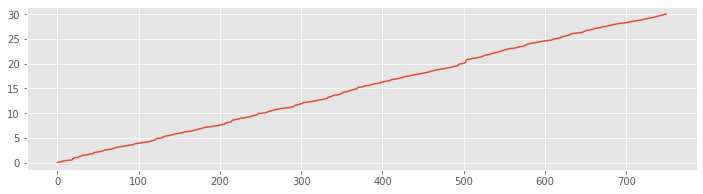

In [6]:
plot(SpikesLow)
show()

<div class="question">


    
**Q.** What went wrong here? How do we interpret this plot?




    
**A.** These data are stored as a sequence of $N$ time stamps representing an increasing sequence of times at which the neuron spiked. When we run the plot command with only one input vector, we plot an index that runs from 1 to $n$ (the length of the vector) on the $x$-axis against the numerical values in that vector on the $y$-axis. Therefore the plot shows an increasing line where the $x$-axis represents the spike number and the $y$-axis represents the spike time. Notice that the vector ends at an $x$-axis value of 750, which corresponds to the length of the vector. Also, the values on the $y$-axis range from 0 to 30; these correspond to times starting near 0 s and ending near 30 s, as we expect for the 30 s recording. Although this plot is not immediately useful, the results are consistent with our expectations for the data.



</div>

Instead of the data representation above, we would like to plot the spike train data as a set of points in a single row with $x$-coordinates that occur at the spike times. One way to produce such a plot is the following:

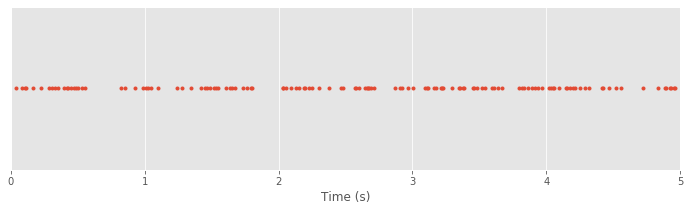

In [7]:
import numpy as np  # Import the NumPy module
plot(SpikesLow, np.ones_like(SpikesLow), '.')  # Plot spikes as a row,
plt.xlim([0, 5])                                # ... display times (0, 5) s
plt.xlabel('Time (s)')                          # ... label the x-axis
plt.yticks([])                                  # ... remove y-axis ticks
show()

<div class="question">
    
**Q.** The first line of code imports the NumPy module. What’s happening in the second line of this code?

**A.** The plot function receives three inputs. The first input defines the $x$-axis values for the plot, which here are the spike times. The second input is itself a function: 

    np.ones_like(SpikesLow). 
  
The function `ones_like` produces an array filled entirely with 1s that is the same dimensions as `SpikesLow`. The last input to `plot` instructs Python to display the data using the dot symbol. To summarize, we’re calling the `plot` command to display 

* $x$-axis values: spike times in the low ambient light condition
* $y$-axis values: 1

as blue dots. The next two commands set the range of the $x$-axis (in this case from 0 s to 5 s) and provide an $x$-axis label. The last command removes the $y$-axis tick marks since they don't carry any real information in this case.

</div>

In the plot of the spike train above each spike time corresponds to a blue dot at a $y$-axis value of 1. The value on the $y$-axis is arbitrary. We could have chosen to use a $y$-axis value of 2 or -100 or 412. What matters is the $x$-axis, which indicates the time at which each spike occurs in the 5 s interval.

To compare the spiking in the low- and high-light conditions, we can plot both in the same figure:
<a id="fig:8.2b"></a>

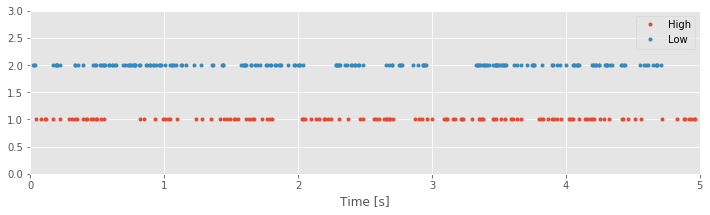

In [8]:
plot(SpikesLow, np.ones_like(SpikesLow), '.')  # Plot the low-light condition spikes
plot(SpikesHigh, 2 * np.ones_like(SpikesHigh), '.')  # ... and the high-light condition spikes 
plt.xlim([0, 5])              # Display times 0 to 5 s on the x-axis
plt.ylim([0, 3])              # ... and set the y-axis limits
xlabel('Time [s]')            # ... label the x-axis
plt.legend({'Low', 'High'})   # ... show a legend
show()

<div class="question">


    
**Q.** What's happening in the fifth line of this code segment?

    
**A.** The fifth line of this code segment is similar to the second line, but it plots the data for the high ambient light condition. The first input to the `plot` function is the variable `SpikesHigh`. The second input to `plot` is a function; here we’re creating an array of 1s, this time with dimensions to match the variable `SpikesHigh`. Notice that we multiply this array by a scalar value of 2; this command acts to create a vector of 2s with the same dimensions as the vector `SpikesHigh`. The last input to `plot` indicates to display the data using another dot symbol. To summarize, here we’re calling the `plot` command to display

* x-axis values: spike times in the high ambient light condition 
* y-axis values: 2.

</div>

<div class="question">
    
**Q.** Explain why the following command fails to execute:

    plot(SpikesLow, np.ones_like(SpikesHigh), '.')

</div>

With the data visualized in this way, we’re now able to ask an interesting question: What structure do you notice in the two spike trains [(figure)](#fig:8.2b)? At first glance, your answer might be “not much.” Spikes occur fairly regularly throughout the 5 s interval under both conditions. Perhaps a careful visual inspection suggests there are fewer spikes in the low-light than in the high-light condition. But the spike times themselves do not seem to be directly comparable between these conditions. Often, when we examine data from a stimulus response experiment, we expect to see regions where spiking activity increases or decreases as a function of a changing stimulus. In this case, the stimulus is the ambient light level, which remains constant over the entire experiment. How else can we analyze these data and identify differences in the spiking activity (if any) between the two conditions?

<div class="question">

**Q.** Up to now, we've plotted a 5 s interval of data that begins at time 0 s. Through visual inspection, do you find similar conclusions for other 5 s intervals chosen from the data?

</div>

[Back to top](#top)

<a id="isi"></a>
### Examining the Interspike Intervals

So far, we have examined the long-term structure of the spiking over multiple seconds. Let’s now focus on the short-term structure that occurs within a single second or less. Instead of plotting 5 s of spike train data, let's plot an interval of 1 s:

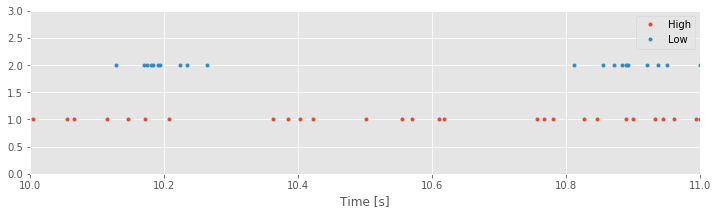

In [9]:
plot(SpikesLow, np.ones_like(SpikesLow), '.')  # Plot the low-light condition spikes
plot(SpikesHigh, 2 * np.ones_like(SpikesHigh), '.')  # ... and the high-light condition spikes 
plt.xlim([10, 11])              # Display times 0 to 5 s on the x-axis
plt.ylim([0, 3])                # ... and set the y-axis limits
xlabel('Time [s]')              # ... label the x-axis
plt.legend({'Low', 'High'})     # ... show a legend
show()

<div class="question">

**Q.** The code above was copied and pasted from the previous section with one minor update to change the time interval. What adjustments did we need to make to the code so that we see an interval of 1 s instead of 5 s?

</div>

Inspecting smaller time intervals, you might notice bursts of spikes that cluster near each other in time, interspersed with longer periods that contain less spiking. These patterns of bursts and quiescence look different between the low- and high-light stimuli. Visual inspection is an important tool, but we would like a quantitative result. How might we compare this fine temporal structure in the two conditions?

One approach to further characterizing the differences in spiking between the two conditions is to transform the data. One of the most useful transformations focuses on the waiting times between the spikes, or interspike intervals (ISIs), instead of the spike times themselves. We can compute the ISIs for the two conditions as follows:

In [10]:
ISIsLow = np.diff(SpikesLow)    # Compute ISIs in the low-light condition
ISIsHigh = np.diff(SpikesHigh)  # Compute ISIs in the high-light condition

<div class="question">


    
**Q.** How do these commands represent the ISIs of the data?




    
**A.** Let’s focus on the first command, which defines the variable ISIsLow. Here, we use the function `diff()` with input `SpikesLow`. If you have not seen the command `diff()` before, look it up using `np.diff()?`. Briefly, the `diff()` command computes the difference between adjacent elements of the input. In this case, the vector `SpikesLow` represents the times at which spikes occur. Therefore, the difference between adjacent elements of `SpikesLow` produces the time interval or waiting time between successive spikes. To further explore the concept of an ISI, let’s write the spike times as a vector,

$$
v = {t_1, t_2, t_3, ..., T_N}, 
\tag{2}
$$

where $t_i$ is the time of the $i^{th}$ spike. The difference between the first two adjacent elements of $v$ is 

$$
t_2 - t_1
\tag{3}
$$

By convention, the `diff()` function subtracts the first element from the second. In words, this difference represents the time of the second spike ($t_2$) minus the time of the first spike ($t_1$), or the first interspike interval in the data. The difference between the next two adjacent elements of $v$ is

$$
t_3 - t_2
\tag{4}
$$

which is the second ISI, and so on. In this way, `diff()` converts the spike times in the vector `SpikesLow` into interspike intervals saved in the variable `ISIsLow`.



</div>

<div class="question">

**Q.** Consider the variables `ISIsLow` and `ISIsHigh`. How do the sizes of these variables compare to the sizes of the corresponding spike trains `SpikesLow` and `SpikesHigh`, respectively? *Hint:* Given $N$ spikes, how many ISIs must occur?

</div>

The variables `ISIsLow` and `ISIsHigh` are vectors, and we can visualize these vectors using the same tools we’ve applied to visualize vectors in other scenarios. For example, we may simply plot these vectors:

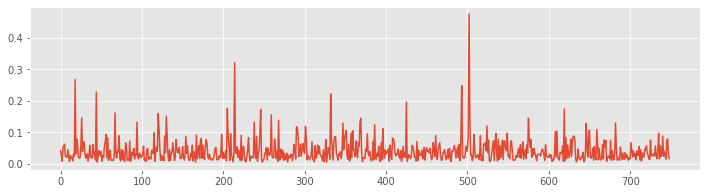

In [11]:
plot(ISIsLow)
show()

The x-axis is the vector index, which ranges from 1 to the length of the vector ISIsLow. The y-axis is the value of the ISI at each index. We see that the ISI values range from small times (less than 0.05 s) to large times (over 0.4 s). In this way, the visualization provides some insight into the ISI values for the low-light condition.

<div class="question">

**Q.** Plot the ISI vector for the high-light condition and compare it to the ISI vector for the low-light condition. What similarities and differences do you notice in the ISIs from the two conditions?

</div>

<div class="question">

**Q.** What is the smallest ISI you expect to observe for a neuron? Would you be surprised to find an ISI of less than 1 second? of less than 1 millisecond? of less than 1 nanosecond?

</div>

Plots of the ISI vectors provide some information about the data (e.g., the approximate range of the ISI values), but there’s more insight to be gained. To that end, let’s now implement another approach to visualizing these types of data: the histogram. The idea of a histogram is to count the number of occurrences of each value in the data. In this case, we count the number of times we observe an ISI value in different bins of time. Let’s define the time bins for the histogram. Inspection of the ISI data for the low-light condition reveals values that range from near 0 s to over 0.4 s. Therefore, we choose the following time bins:

Bin 0 [0.00 0.01] 

Bin 1 [0.01 0.02] 

Bin 2 [0.02 0.03] 

Bin 3 [0.03 0.04] 

Bin 4 [0.04 0.05] 

Bin 5 [0.05 0.06] 

Bin 6 [0.06 0.07] 

...

Bin N [0.49 0.50]

The bins begin at time 0 s and end at time 0.5 s, with a bin size of 0.01 s. The purpose of the histogram is to count the number of times the data values fall into each bin. Notice that we’ve chosen the range of bins to extend beyond the observed range of data ISIsLow; that’s fine, and we expect to count no values in the bins near 0.5 s. To further explore this counting process, let’s examine the first eight values of the data `ISIsLow`:

<div class="python-note">

Recall that Python uses *zero-based indexing*. This means that elements in arrays are numbered starting with 0, which is why we labeled the first bin "Bin 0" instead of "Bin 1".

</div>

In [12]:
ISIsLow[:8]

array([0.04098354, 0.02902169, 0.00746714, 0.05205904, 0.05553601,
       0.06204051, 0.02267623, 0.02132764])

We see that the first value of ISIsLow is approximately 0.0410. In which bin does this value belong? Examining the list of bins, we find that `ISIsLow[0]` lies in bin 4, so we increment the number of counts in bin 4 by 1. The second value of the vector `ISIsLow` (`ISIsLow[1]` $\approx$ 0.0290) lies in bin 2, so we increment the number of counts in bin 2 by 1. The third value, `ISIsLow[2]` $\approx$ 0.0075, lies in bin 0, so we increment the number of counts in bin 0 by 1. The fourth value, `ISIsLow[4]` $\approx$ 0.0521, lies in bin 5, so we increment the number of counts in bin 5 by 1. And the fifth value, `ISIsLow[4]` $\approx$ 0.0555, also lies in bin 5, so we again increment the number of counts in bin 5 by 1.

<div class="question">
    
**Q.** At this point, for the first five entries of the vector `ISIsLow`, how many counts are there in each bin?

    
**A.** We find for the first five ISIs in the low-light condition, zero counts in all bins except

Bin 0: 1 count 
Bin 2: 1 count 
Bin 4: 1 count 
Bin 5: 2 counts 
    
Notice that only four bins have counts and that bin 5 has two counts; for the first five ISIs in the low-light condition, we observe two ISIs in the interval (0.05, 0.06).

</div>

<div class="question">

**Q.** Repeat the binning procedure for the first eight ISIs observed in the high-light condition. Which bins have 1 or more counts for the first eight ISI values? What is the number of counts in each of these bins?

</div>

<div class="question">

**Q.** Consider the first eight ISI values. In the previous question, you placed each of these values in a bin. Sum the counts across all bins. What do you find? Think about the value you compute; does the result make sense?

</div>

Of course, we’re free to choose any interval of bins for the histogram. In the preceding examples, we chose a bin size of 0.01 s = 10 ms. Based on our understanding of a neuron, we might instead choose to examine a smaller bin size, 0.001 s = 1 ms. Let’s do so now, and examine the histogram of all ISIs for the low-light condition. Of course, with enough patience, we could examine by hand each ISI value from the low-light condition and place each value in the correct 1 ms bin. However, this process would be time consuming and extremely error prone. Instead, the process of binning the ISI data is better done in Python. To create a histogram of all the ISI data in the low-light condition is straightforward:

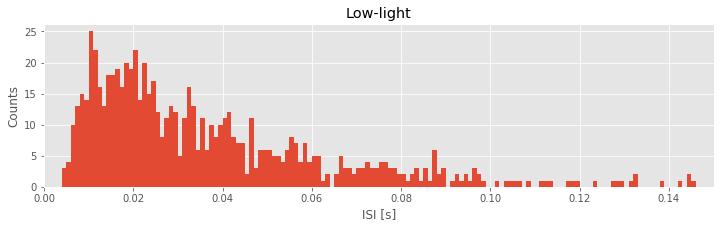

In [13]:
bins = np.arange(0, .5, 1e-3)  # Define the bins for the histogram
plt.hist(ISIsLow, bins)        # Plot the histogram of the ISI data
plt.xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
xlabel('ISI [s]')              # ... label the x-axis
ylabel('Counts')               # ... and the y-axis
title('Low-light')             # ... give the plot a title
plt.show()

In the first line of this code segment, we define the bins. These bins start at time 0 s and end at time 0.499 s, and the size of each bin is 0.001 s. We then call the function `hist()` with two inputs: the first input is the variable we’d like to examine (here, `ISIsLow`, the ISIs in the low-light condition), and the second input is the bins. The function `hist()` computes the histogram and displays the result. By setting the $x$-axis limit with `xlim()`, we’ve chosen to examine the ISI values from 0 ms to 150 ms. We’ve also labeled the axes in the resulting figure. Notice that the $x$-axis indicates the binned ISI intervals, while the $y$-axis indicates the number of counts in each bin.

<div class="question">


    
**Q.** Repeat this procedure to create a histogram of the ISI data in the high-light condition. Use the same bins we applied in the low-light condition (i.e., a bin size of 1 ms, extending from 0 s to 0.5 s). What do you find? *Hint:* Compare your answer to plot above.



</div>

Let's visualize the distributions of ISIs in both conditions next to each other: <a id="fig:8-5"></a>

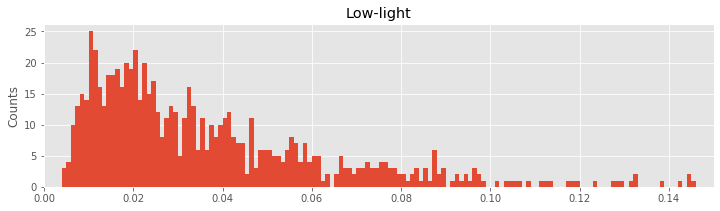

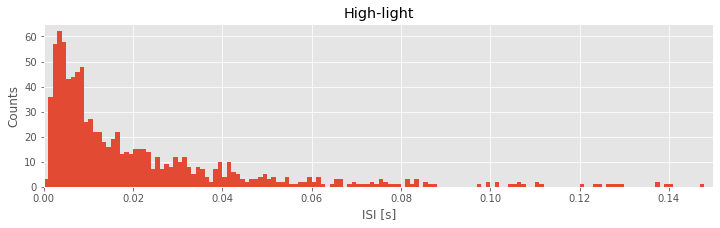

In [14]:
plt.hist(ISIsLow, bins)        # Plot the histogram of the low-light ISI data
plt.xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
ylabel('Counts')               # ... label the y-axis
title('Low-light')             # ... give the plot a title
plt.show()

plt.hist(ISIsHigh, bins)       # Plot the histogram of the high-light ISI data
plt.xlim([0, 0.15])            # ... focus on ISIs from 0 to 150 ms
xlabel('ISI [s]')              # ... label the x-axis
ylabel('Counts')               # ... and the y-axis
title('High-light')            # ... give the plot a title
plt.show()

<div class="question">

**Q.** Describe the features of the two histograms. What features of the ISI distributions are similar for the two conditions? What features are most strikingly different?

</div>

In the ISI histogram of the low-light condition data, very few counts occur at small ISI values (near 0 ms) and high ISI values (beyond approximately 100 ms). Instead, the distribution of counts is broadly peaked in the approximate interval 5–20 ms.

<div class="question">


    
**Q.** What does the ISI distribution reveal about the spiking activity in the low-light condition? From this ISI distribution, could you sketch a spike train consistent with these data?




    
**A.** We conclude from the ISI distribution that many spikes are separated by time intervals 5–20 ms. So, we might be tempted to imagine near-periodic spiking with a period 5–20 ms:

<a id="fig:8.6a"></a>

![Cartoon representation of spiking activity.](imgs/8-6a.png "Near-periodic spiking, with period 5&mdash;20 ms.")

However, the histogram contains additional structure beyond the single broad peak. Indeed, the histogram has a long tail, with counts extending up to 150 ms. Therefore, the intervals between spikes are varied. We often see ISIs in the 5–20 ms interval, but we also find much longer ISIs (e.g., from 50 to 150 ms). The structure of the ISI histogram is consistent with bursting activity, which consists of intervals of rapid spiking interspersed with quiescence:

<a id="fig:8.6b"></a>

![Cartoon representation of spiking activity.](imgs/8-6b.png "Bursting activity, with both short and long intervals between spikes.")

The intervals of rapid spiking produce many shorter ISIs, and the longer intervals produce (typically fewer) longer ISIs. We may conceptualize a bursting neuron as having two time scales: fast and slow. From the shape of the histogram of the low-light condition, we conclude that the spike train data in the low-light condition are more consistent with bursting activity than with periodic, metronome-like spiking activity.
    


</div>

<div class="question">

**Q.** What does the ISI distribution reveal about the spiking activity in the high-light condition? From this ISI distribution, could you sketch a spike train consistent with these data?

</div>

Let’s now consider the two ISI histograms representing the spiking activity from the two conditions. We note that both histograms show no ISI values below 0 ms. This is to be expected; the intervals between spikes cannot be negative. Both histograms also show broad peaks at 5–20 ms, indicating that a large number of short ISIs appear in the spike trains. In addition, both histograms possess long tails (i.e., counts of ISIs at larger bins, beyond 50 ms). A reasonable conclusion is that both neurons exhibit bursting activity, intervals of rapid spiking separated by periods of quiescence. However, a prominent difference exists between the ISI histograms in the two conditions. In the high-light condition, the proportion of small ISIs is much larger. The visualizations of the ISI histograms provide additional evidence of the similarities and differences in the spiking activity from the two conditions. We continue to investigate these two datasets—and build our scientific conclusions—in the next sections.

<div class="question">

**Q.** We claim that the neuron exhibits bursting activity in both histograms. But clearly the two ISI histograms are different. How does the bursting activity differ in the low- and high-light conditions? *Hint:* Consider the impact of the large proportion of small ISIs in the high-light condition.

</div>

<div class="question">

**Q.** So far, we’ve investigated two bin sizes: 10 ms and 1 ms. How do the shapes of the histograms above depend on the bin size used? Was 1 ms a good choice in this case? Why, or why not?

</div>

[Back to top](#top)
<a id="bsi"></a>
### Examining Binned Spike Increments

Another common approach to analyzing spiking data is to discretize time into bins of fixed width and count the number of events that occur in each time bin. The sequence of spike counts across all the bins is sometimes called the increment process for the spike train. When the time bins are sufficiently small, say, 1 ms for typical spike train data, the resulting increment process is just a sequence of zeros and ones. In this case, the time bins are so small that the probability of more than one spike occurring in each bin is zero or negligibly small.<sup><abbr title="The biophysical mechanisms that produce a spike support this statement. After generating a spike, the neuron experiences a refractory period typically lasting a few milliseconds, in which generating a subsequent spike is very unlikely.">note</abbr></sup> Each tiny time bin then contains a spike (and we assign that bin a value of 1) or does not (and we assign that bin a value of 0). This idea of representing the spike train as a sequence of zeros and ones for small bin increments will be important when we build statistical models of the spike trains in a [later chapter](../09/). In this section, we compute the increment process with multiple bin sizes in order to characterize the amount of variability in the spiking data and to examine temporal dependencies between spikes.

Let’s bin the spike train data of the low-light condition into time bins of size 50 ms. To do so, we make use of the function `histogram()`:

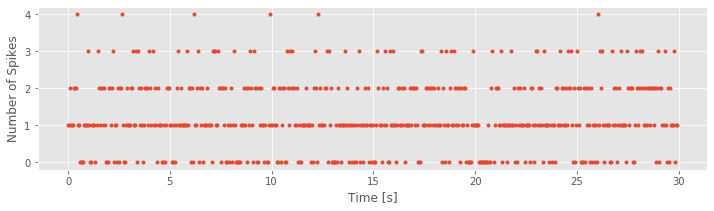

In [15]:
time_bins = np.arange(0, 30, 0.05)                    # Define the time bins
IncrementsLow50, _ = np.histogram(SpikesLow, time_bins)  # ... and compute a histogram of the data
plot(time_bins[:-1], IncrementsLow50, '.')               # Plot the resulting counts over time
xlabel('Time [s]')                                       # ... with axes labeled
ylabel('Number of Spikes')
show()

Notice that, in this case, we use the function `histogram()` in a new way. Instead of simply generating a plot, we call the function with the output variable `IncrementsLow50`. This variable `IncrementsLow50` is a vector containing the number of counts (i.e., the number of spikes) in each 50 ms increment. The time bins (`time_bins`, the second input to the function `histogram`) is a vector containing the bin locations in time. In this case, the time bins start at time 0 s and end at time 30 s, with 0.05 s between bins. The variable name `IncrementsLow50` is quite descriptive. It reminds us that the variable represents the increments process in the low-light condition with a time bin of 50 ms.

<div class="python-note">

A descriptive choice of variable name is often useful.

</div>

<div class="question">

**Q.** What can you say about the spike train data based on the increment process that we just plotted? Approximately how often do you observe a 50 ms increment with zero spikes? With four spikes?

</div>

One question that arises quite often is how variable these binned counts are. To illustrate this variability, let’s consider two scenarios. In the first, consider a neuron that fires perfectly regularly, like a metronome. In this case, we expect the number of spikes in each time bin to be nearly identical. On the other hand, consider the scenario of a neuron that fires in irregular bursts. In this case, we expect much more variability in the number of spikes in each time bin, depending on whether a time bin contained a burst of spikes or a quiet period. To characterize this variability, a standard measure to compute is the sample Fano factor (FF). It’s easy to define the Fano factor: FF is the sample variance of the increment process divided by the sample mean of the increment process. The implementation of FF in Python is also relatively simple:

In [16]:
FF50Low = IncrementsLow50.var() / IncrementsLow50.mean()
print('FF50Low =', FF50Low)

FF50Low = 0.7164927285225824


<div class="question">

**Q.** How do we interpret this FF value?

</div>

To answer that question, we need to introduce the concept of a Poisson process. A Poisson process is a model for a spiking process for which each spike occurrence is independent of every other spike occurrence. In other words, the probability of a neuron spiking at any instant does not depend on when the neuron fired (or did not fire) previously. A useful way to conceptualize this process is as a coin flip. For example, consider the following outcome of 20 coin flips:

HTHTTTHTTTTTHHHHHHTH 

where H indicates heads, and T indicates tails.

<div class="question">


    
**Q.** Based on your intuitive knowledge of a coin flip, does the result of a chosen coin flip depend on any other coin flip?




    
**A.** No. Consider, for example, the fifth coin flip. In the example outcome, the fifth coin flip resulted in T (tails). Does this result depend on the previous coin flip? on the next coin flip? on the first coin flip? on a future one-hundredth coin flip? In all cases, intuition suggests that it does not. Each coin flip is independent of every other coin flip. That’s the assumption we make in assuming a Poisson process as a model for spiking activity: each spike occurrence is independent of every other spike occurrence.



</div>

The Poisson process is rarely an accurate model for spike train data. Our biological knowl- edge reveals that the occurrence of a spike does depend on the occurrence of previous spikes (e.g., because of the refractory period of a neuron, we do not expect a spike to occur immediately after another spike). However, the Poisson process has many nice theoretical properties, that make it a good model against which to compare the data. For example, for any Poisson process, the number of spikes in any time interval has a Poisson probability distribution for which the theoretical variance and mean are equal (see the [appendix](#appendix) at the end of the chapter).

<div class="math-note">

The theoretical Fano factor for a Poisson process is exactly equal to 1.

</div>

When measuring the variability of the increments of a spike train, we typically compare it to the variability of a Poisson process. If we compute a Fano factor well below the value 1 for a particular set of increments, this suggests that the spiking is more regular than a Poisson process for the time scale at which the increments were binned. In this case, spiking activity in the past is influencing the neuron to spike in a more predictable manner in subsequent bins. If we compute a Fano factor well above the value 1, this suggests that the spiking is more variable than a Poisson process for the time scale at which the increments were binned.

For the 50 ms binned spikes in the low-light condition, we obtained a sample Fano factor value of 0.72, well below 1. We might therefore conclude that the spiking data in the low-light condition are more regular (i.e., more like a metronome) than we expect for a Poisson process.

<div class="question">


    
**Q.** What can we conclude about the variability of the counts for the spiking data in the high-light condition?




    
**A.** Repeating the analysis, we find that the sample Fano factor in the high-light condition is 1.78, well above 1. We might therefore conclude that the spiking data in the high-light condition are less regular than we expect for a Poisson process.



</div>

#### Does the observed Fano factor differ from 1?

The preceding results are somewhat unsatisfying. We claimed that in the low-light condition, the calculated Fano factor of 0.72 was well below 1. What if, instead, we calculated a Fano factor of 0.8; is that well below 1? Is a Fano factor of 0.9 well below 1? These questions highlight an important issue when drawing a conclusion from a Fano factor calculation: How far above or below the value of 1 does the calculated Fano factor have to be before we are confident that there is really a statistically significant difference in the variability from a Poisson process? After all, even if we had spiking from a true Poisson process, from one experiment to the next we would expect to find different values for the increments, and values for the sample Fano factor that fluctuate slightly above and below 1. Fortunately, a bit of statistical theory can help us out. It can be shown that the distribution of Fano factors that we might compute from a Poisson process follows a gamma distribution with shape parameter $(N - 1)/2$ and scale parameter
$2/(N - 1)$, where $N$ is the number of time bins used in the Fano factor calculation [[Eden & Kramer, 2010](https://doi.org/10.1016/j.jneumeth.2010.04.012)].

<div class="question">
    
**Q.** What is the correct value of $N$ for the increment process computed above and saved in the variable IncrementsLow50?
  
**A.** We find in Python that 

    IncrementsLow50.shape
        
is 600. Therefore, N = 600. This makes sense; 600 time bins of 50 ms duration fit between 0 s and 30 s.

</div>

With the value of $N = 600$ now determined, let’s plot the gamma distribution and investigate its shape:

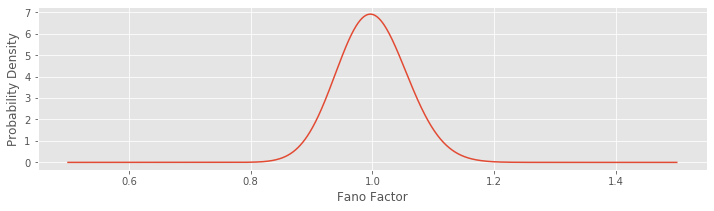

In [17]:
from scipy.stats import gamma   # Import the gamma object from the SciPy stats toolbox
N = IncrementsLow50.shape[0];   # Determine number of time bins.
shape = (N - 1) / 2             # Define the shape parameter of the gamma function
scale = 2 / (N - 1)             # ... and the scale parameter 
FF = np.linspace(.5, 1.5, 1000) # Define possible FF values
Y = gamma.pdf(FF, shape, 
              scale=scale)      # ... compute gamma distribution,
plot(FF,Y);                     # ... and plot it
xlabel('Fano Factor')           # ... with axes labeled
ylabel('Probability Density')  
show()

Notice that we’re evaluating the function `gamma.pdf()`, which returns as output the gamma probability density function. We provide three inputs to this function. The first specifies a range of Fano factors to investigate (here we choose Fano factors ranging from 0.5 to 1.5; we choose a large number of Fano factor values to make a smooth plot of the gamma distribution). The second and third inputs to the function specify the shape and scale parameters of the gamma distribution.

When $N$ is large, as it is here, the gamma distribution looks like a normal distribution (i.e., like a bell-shaped curve). We can use this distribution to construct an interval where we would expect the Fano factor to lie if the data were generated by a Poisson process. More specifically, if the data were generated by a Poisson process, then we would expect the Fano factor to lie in the 95% confidence interval around the value of 1. Let’s construct this 95% confidence interval:

In [18]:
gamma.ppf([.025, .975], shape, scale=scale)

array([0.88985257, 1.11648138])

In this case, we use the function `gamma.ppf()` to compute the gamma inverse cumulative distribution function (or percentiles). The first input specifies the boundaries of the probabilities of interest, which range from 2.5% to 97.5%, to encompass 95% of the probability mass around the value of 1. The next two inputs specify the shape and scale parameters of the gamma distribution. Evaluating this line of code, we find the interval (0.890, 1.116). Therefore, if we observed a true Poisson process with N = 600 bins and computed the Fano factor, we would not be surprised to find values between 0.890 and 1.116. However, the observed Fano factor for an increment process with 50 ms bins in the low-light condition is well outside of this range; this result suggests that it is very unlikely that these data were generated by a Poisson process. Instead, it’s more likely that these data were generated by a process with less variability in the low-light condition (FF = 0.72).

<div class="question">


    
**Q.** Consider the Fano factor for the high-light condition. Do you believe these data were generated by a Poisson process? Why, or why not?




    
**A.** We found for the high-light condition a Fano factor of 1.78 (again using an increment process with 50 ms bins). This calculated value is well above the interval expected for a Poisson process. We therefore reject the hypothesis that these data were generated by a Poisson process. Instead, we observe more variability in the high-light condition than expected for a Poisson process (with $N = 600$).



</div>

<div class="question">

**Q.** How do the results for the Fano factor change in each condition with different choices for the bin size of the increment process (e.g., 25 ms, 100 ms, 500 ms)? Note that by changing the bin size, you also change $N$. *Challenge*: See if you can write a function that takes the data and desired binwidth as input and returns the Fano factor and 95% confidence interval.

</div>

[Back to top](#top)
<a id="autocorrelations"></a>
### Computing Autocorrelations for the Increments

Another way to characterize the history dependence structure of a spike train is with the *autocorrelation* function of the increments. A correlation coefficient describes the degree of linear dependence between any two variables. The value of the correlation ranges from -1 to 1. A correlation value of -1 indicates a perfect linear relation between the two variables with a negative slope. A value of 0 indicates no linear relation between the two variables. And a value of 1 indicates a perfect linear relation between the two variables with a positive slope. Any other value indicates that one variable can be predicted using a linear function of the other, but that prediction will be imperfect; the closer the value is to $\pm$1, the better the prediction will be. The sign of the coefficient indicates the slope of the linear relation. The following figure shows scatterplots for a variety of possible relations between two variables, and the values of the correlation coefficients.

![Correlation values for example relations between two variables.](imgs/8-9.png "Variables are plotted, one against the other, on the x-axis and y-axis. Numbers indicate values of the correlation between the two variables.")

Mathematically, the formula for the sample autocorrelation at a lag $L$ is
<a id="eq:5"></a>

$$
\rho_{xx}[L] = \frac{
\sum_{i=1}^{N - L}
(x_i - \overline x)(x_{i+L} - \overline x)
}
{
\sum_{i=1}^{N}(x_i - \overline x)^2
}
\tag{5}
$$

where $x_i$ is the $i^{th}$ data point, and $\overline x$ is the sample mean of the data over index $i$.

<div class="question">


    
**Q.** This formula is rather complicated, so let's consider a simple case: $L = 0$. What is $\rho_{xx}[0]$ at lag 0?




    
**A.** To answer this, let's substitute $L=0$ into the mathematical expression fo rthe autcorrelation,


\begin{eqnarray}
\rho_{xx}[0] &=& 
\bigg ( \sum_{i=1}^{N-0} (x_i - \overline x)(x_{i+0} - \overline x) \bigg ) 
\bigg / 
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\\
&=&
\bigg ( \sum_{i=1}^{N} (x_i - \overline x)(x_{i} - \overline x) \bigg ) 
\bigg / 
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\\
&=&
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\bigg / 
\bigg ( \sum_{i=1}^N (x_i - \overline x)^2 \bigg ) 
\\
&=& 1.
\end{eqnarray}

At $L=0$, the autocorrelation is by definition equal to 1. In words, an individual dataset $x$ is perfectly correlated with itself at zero lag.



</div>

To gain some intuition for the autocorrelation, let’s consider the following relatively simple increment process:

<a id="fig:8-10a"></a>

![Example data for visual inspection of autocorrelation of an increment process.](imgs/8-10a.png "Data x as a function of time (arbitrary units).")

Our goal is to understand the autocorrelation of these data, labeled $x$. From visual inspection of the figure, we conclude that the data $x$ have mean 0, so that $\overline x = 0$; note that the data appear to oscillate between equal and opposite values over time. For simplicity, let’s focus on the numerator of equation (<a href="#eq:5" class="thumb">5<span><img src="imgs/eq5.png"></span></a>). At lag zero (i.e., $L = 0$), the numerator of (<a href="#eq:5" class="thumb">5<span><img src="imgs/eq5.png"></span></a>) tells us to multiply the data by themselves at each time index, and then sum the product. To visualize this multiplication and sum, consider multiplying the data in figure above by the following data at each index in time and then summing the result.

<a id="fig:8-10b"></a>

![Example data for visual inspection of autocorrelation of an increment process.](imgs/8-10b.png "Data x at lag L=0.")

<div class="question">


    
**Q.** What is the value of this sum?




    
**A.** We can’t answer this question without knowing the values of $x$. However, we can deduce the sign and relative size of the sum. At a time index where $x$ is positive, the product is positive; and at a time index where $x$ is negative, the product is still positive. So, the product at each time index will always be positive or zero. Therefore, we expect the sum to be a positive number. And if we add many terms, we expect this sum to be large. So, we may conclude that the value of this sum will be a large, positive number. Note that this number is the numerator of the autocorrelation. At $L = 0$, the numerator equals the denominator in (<a href="#eq:5" class="fig">5<span><img src="imgs/eq5.png"></span></a>) and the autocorrelation at lag zero is 1.



</div>

Let’s consider the numerator of the autocorrelation (<a href="#eq:5" class="fig">5<span><img src="imgs/eq5.png"></span></a>) for a small positive lag (i.e., $L > 0$). We can think of the small positive lag as shifting the data $x$ a little bit to the right:

<a id="fig:8-10c"></a>

![Example data for visual inspection of autocorrelation of an increment process.](imgs/8-10a.png "Data x.")

![Example data for visual inspection of autocorrelation of an increment process.](imgs/8-10c.png "Data x at lag L>0.")

Now, to compute the numerator of the autocorrelation, we multiply $x$ by a shifted version of $x$ at each time index and then sum the result. In this case, we find some indices where the product of $x_i$ and $x_{i+L}$ is positive, and some indices where the product of $x_i$ and $x_{i+L}$ is negative; an example of an index where the product is negative is indicated above by the black circle. Visual comparison of figures two plots suggests that the product will be positive more often then negative. Therefore, we expect the sum of these products to still be positive, although not as large as we found for the $L = 0$ case. You may have noticed some points where the data do not overlap, at the far right and far left of the figure. At these locations, the product is zero.

<div class="question">

**Q.**  Consider the autocorrelation of the data $x$ at the positive lag $L_1$ shown here:

![Example data for visual inspection of autocorrelation of an increment process.](imgs/8-10d.png "Data x at lag L1>L.")

What is the sign (positive or negative) and relative size of the numerator of the autocorrelation at this lag?

</div>

Let’s return to the spike train data of interest here, recorded in the low- and high-light conditions. For the corresponding spike train increments, the autocorrelation at a particular lag describes the relation between the spike counts in different bins separated by that lag. The autocorrelation function describes the autocorrelation across a range of lags over which we are interested. Given our visualizations of the ISI histograms (<a href="#fig:8-5" class="fig">figure<span><img src="imgs/8-5.png"></span></a>), we might expect relations between spiking events to extend up to 200 ms.

Let’s compute the autocorrelation for increment processes deduced from the spike train data in the low-light condition. We compute the autocorrelation of the 50 ms increment process for lags ranging from 0 to 200 ms. We need only three lags to cover this range; lag 1 covers 50–100 ms, lag 2 covers 100–150 ms, and lag 3 covers 150–200 ms. We can define a function to compute the autocorrelation using the function `correlate()` from the NumPy module:

In [19]:
def autocorr(x, lags):
    xcorr = np.correlate(x - x.mean(), x - x.mean(), 'full')  # Compute the autocorrelation
    xcorr = xcorr[xcorr.size//2:] / xcorr.max()               # Convert to correlation coefficients
    return xcorr[:lags+1]                                     # Return only requested lags
    
autocorr(IncrementsLow50, 3)

array([1.        , 0.03894992, 0.07055464, 0.04431669])

Our new function `autocorr()` takes two inputs. The first input is the data for which we want to compute the autocorrelation, in this case, the increment process for the low-light condition with 50 ms time bins. The second input is the number of lags to compute. Within the function, we scale the raw autocorrelation so that we instead see correlation coefficients, which range from -1 to 1. Notice that we subtract from `IncrementsLow50` the mean of this variable before computing the autocorrelation. This command outputs a vector with four numerical values corresponding to the autocorrelation at lag indices 0 through 3. The autocorrelation at negative lags is mathematically identical to the autocorrelation at the equivalent positive lags, which is why we exclude them in the third line of the function definition.

<div class="question">


    
**Q.** Examine the numerical values returned by `autocorr()`. What do you find?




    
**A.** As expected, the autocorrelation at zero lag is exactly equal to 1; the data matches itself at lag 0. At lag 1, corresponding to 50–100 ms, the autocorrelation value is 0.04. This positive correlation value indicates that when the number of spikes in one bin is higher than expected, the number of spikes in the next bin tends to be higher than expected. Similarly, when the number of spikes in one bin is lower than expected, the number of spikes in the next bin will also tend to be lower than expected. This effect is small, however, since the autocorrelation is near zero. At lag 2, corresponding to 100–150 ms, the autocorrelation value of 0.07 is again small and positive. At lag 3, corresponding to 150–200 ms, the autocorrelation value remains small and positive at a value of 0.04.



</div>

<div class="question">


    
**Q.** How do we know whether these autocorrelation values are statistically significant?




    
**A.** This can be a difficult question when $N$ is small (less than 30), but for larger $N$ we can approximate a confidence interval about the correlation coefficient using a normal approximation with standard deviation $1/\sqrt N$. In this case, any correlation value exceeding $\pm2/\sqrt N$ is unlikely to be generated by chance and likely reflects real dependence structure. For the increment process considered here, $N = 599$, and the significance bound is $\pm 0.08$. We conclude that none of the lags has significant autocorrelation.



</div>

If we are particularly interested in the fine-scale temporal dependence structure of the spikes, we would do better to compute the autocorrelation function for more finely binned intervals. To that end, let’s repeat the autocorrelation analysis for an increment process that uses 1 ms bins. We first compute a new increment process and then apply the `autocorr()` function to this process.

In [20]:
time_bins = np.arange(0, 30, 0.001)                    # Define the time bins
IncrementsLow1, _ = np.histogram(SpikesLow, time_bins) # ... compute the histogram to create increment process
ACFLow = autocorr(IncrementsLow1, 100)                 # ... and the autocorrelation

<div class="question">


    
**Q.** What is the size of the output variable `ACFLow`? How does this size correspond to the lags?




    
**A.** `ACFLow` is a vector with dimensions 1 $\times$ 101. The 101 values correspond to lag indices 0 to 100 (or lag times 0 ms to 100 ms).



</div>

In order to examie history dependence going back 100 ms, we need 100 lags (because each lag index corresponds to 1 ms). There are now too many values to examine them printed one by one at the command line, so instead we construct a plot fo the autocorrelation function with lag on the $x$-axis and correlation on the $y$-axis. Let's also include in this figure two approximate significance lines at $\pm2/\sqrt N$.

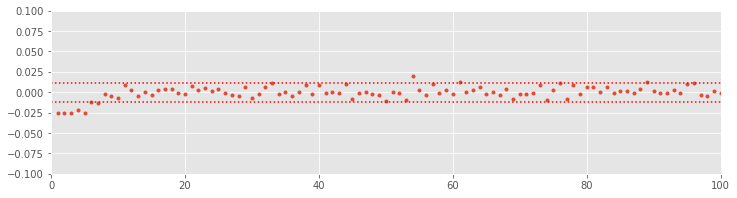

In [21]:
plot(ACFLow, '.')        # Plot autocorrelation vs lags,
N1 = len(IncrementsLow1)                    # ... compute the sample size
sig = 2 / np.sqrt(N1)                       # ... and the significance level
plot([0, 100], [sig, sig], 'r:')           # ... and plot the upper and lower significance lines
plot([0, 100], [-sig, -sig], 'r:')
plt.xlim([0, 100])                          # ... set x-limits
plt.ylim([-.1, .1])                         # ... and y-limits
show()

We see that, the two approximate significance lines at $\pm2/\sqrt N$ suggest significant negative correlation structure is present up to about $6$ ms. This reflects the refractory period of the neuron: if you observed a spike in the previous 6 ms, you are less likely to observe a spike in the next few milliseconds. Beyond this point, the values of the autocorrelation mostly remain between the two significance bounds.

<div class="math-note">

**Alert!** We are using these significance bounds here for exploratory purposes. We are not performing a rigorous statistical test for significance of the autocorrelation at every lag.

</div>

If we choose to perform a rigorous statistical test for the significance of the autocorrelation, we would face the multiple comparisons problem. Briefly, if we perform many independent tests, and each has a 5% chance of reaching significance by chance, then the probability that any of these tests reaches significance by chance can be very large. If we wanted to perform many tests, we would need to control for multiple comparisons by adjusting the significance level so that the probability of any test being significant by chance is small. In the plot above, the significance lines are not corrected for multiple comparisons. Therefore, we accept that some of the correlation values that exceed these bounds may occur by chance. However, it is still very unlikely that all the significant correlations we observed from 1 to 6 ms are occurring purely by chance.

Now that we’ve computed and interpreted the autocorrelation function for the low-light condition, let’s compare it to the autocorrelation in the high-light condition. We repeat our previous commands using the `SpikesHigh` data values and choosing a time bin of 1 ms:
<a id=fig:8-12></a>

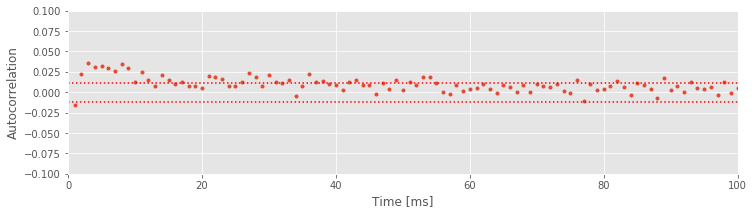

In [22]:
IncrementsHigh1, _ = np.histogram(SpikesHigh, time_bins) # Compute the histogram to create increment process
ACFHigh = autocorr(IncrementsHigh1, 100)                 # ... and the autocorrelation
plot(ACFHigh, '.')                                       # Plot the autocorrelation,
sig = 2 / np.sqrt(len(IncrementsHigh1))                  # ... compute and plot the significance level,
plot([0, 100], [sig, sig], 'r:')                               
plot([0, 100], [-sig, -sig], 'r:')
plt.xlim([0, 100])                                       # ... and set the plot limits
plt.ylim([-.1, .1])
xlabel('Time [ms]')
ylabel('Autocorrelation')
show()

<div class="question">


    
**Q.** Consider the autocorrelation of the spike train data in the high-light condition shown above. What do you observe? How do the autocorrelations differ in the two conditions?

**A.** We find in the high-light condition significant correlation structure going all the way out to about 50 ms. Once again, we see refractoriness reflected in the negative autocorrelation at a lag of 1 ms, but this lasts much less time than in the low-light condition. Instead, there is now significant positive correlation at intermediate lags (approximately 2–50 ms). This positive correlation at short time lags reflects the tendency of the neuron to fire in bursts with small ISIs in the high-light condition; after a spike, another spike is more likely to occur in the next 2–50 ms than in the subsequent 50–100 ms.
</div>

Now that we’ve visualized the autocorrelations in the two light conditions, we can ask an important related question: Are the differences in the autocorrelations between these two conditions real? To answer this, we compute the difference in the autocorrelation functions between the low- and high-light conditions at every lag. If we assume that the firing in each condition is independent, the significance bounds for this difference can be computed by adding the variance of the autocorrelation from each condition. The standard deviation of the autocorrelation for the low-light condition is $1/\sqrt{N_1}$, so the variance of the auto- correlation for the low-light condition is $1/N_1$. For the high-light condition, the variance of the autocorrelation is $1/N_2$. We plot the differenced autocorrelations and the significance bounds:

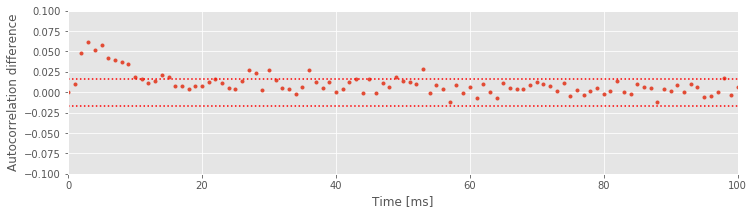

In [23]:
N2 = len(IncrementsHigh1)
ACFDiff = ACFHigh - ACFLow                    # Compute differences of autocorrelations
plot(ACFDiff, '.')                            # ... and plot them
sd = np.sqrt(1/N1+1/N2)                      # ... with significance bounds
plot([0, 100], [2 * sd * x for x in [1, 1]], 'r:')
plot([0, 100], [-2 * sd * x for x in [1, 1]], 'r:')
plt.xlim([0, 100])                            # Set the plot limits and label the axes
plt.ylim([-.1, .1])
xlabel('Time [ms]')
ylabel('Autocorrelation difference')
show()

The results suggest significant differences in the autocorrelation between the two conditions at intermediate time lags (at approximately 2–50 ms). These are the same time lags we identified with bursting activity in the high-light condition. This suggests that the neuron fires with more intermediate ISIs in the bursting range in the high-light condition.

[Back to top](#top)
<a id="acISI"></a>
### Computing Autocorrelations of the ISIs

The autocorrelation of the increments indicates the amount of time for which there are dependencies in the spiking data. In the high-light condition, we found large correlation values extending out to approximately 50 ms. This could be a consequence of the influence of patterns of many spikes with shorter ISIs or of single spikes with longer ISIs. We can distinguish between these possibilities by looking at the autocorrelation of the sequence of ISIs. In this case, the lag represents the number of spikes in the past rather than the amount of time in the past. If the dependence is only due to the last spike, we expect the ISIs to be uncorrelated at any nonzero lag. This would necessarily be true for data from a Poisson process. If we see correlation between ISIs, this suggests that the data do not come from a Poisson process and that the past spiking has an influence over multiple spikes. To investigate this, let’s compute the autocorrelation of the sequence of ISIs for the low-light condition:
<a id="fig:8-14"></a>

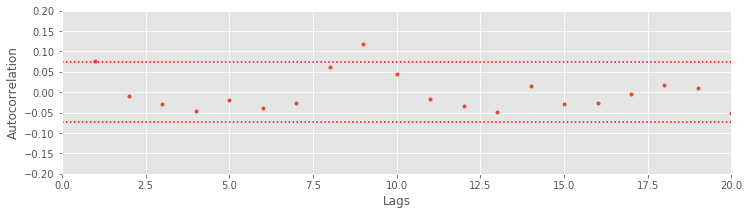

In [24]:
# Compute and plot the autocorrelation of the low-light ISIs,
ISI_ACF_Low = autocorr(ISIsLow, 20)
plot(ISI_ACF_Low, '.')
# ... with upper and lower significance lines,
N3 = len(ISIsLow)
sd = 1 / np.sqrt(N3)
plot(2 * sd * np.ones_like(ISI_ACF_Low), 'r:')
plot(-2 * sd * np.ones_like(ISI_ACF_Low), 'r:')
# Set plot limits and label axes
plt.xlim([0, 20])
plt.ylim([-.2, .2])
xlabel('Lags')
ylabel('Autocorrelation')
show()

Notice that we include confidence bounds determined by the size of the sequence of interest (in this case, the length of the ISIs).
We see that the autocorrelation function has just a few isolated lags that are outside of the significance bounds. This could indicate a weak relation at particular lags or could be due to chance. Assuming the latter suggests that the data may come from a renewal process, a spiking process with independent ISIs for which the probability of a spike at any time only depends on the time of the most recent spike. One advantage of working with renewal processes is that it is fairly easy to write down and fit statistical models to the data. That is our next step.

<div class="question">

**Q.** Compute the correlation between ISIs for the data in the high-light condition. What do you find? Are these data consistent with a renewal process?

</div>

[Back to top](#top)
<a id="models"></a>
### Building Statistical Models of the ISIs

In the previous sections, we constructed autocorrelation functions of the increment processes and autocorrelation functions of the sequences of ISIs. The former suggested dependence going back up to $\approx$ 50 ms (<a href="#fig:8-12" class="fig">figure<span><img src="imgs/8-12.png"></span></a>), while the latter suggested that the spiking at any time depends only on the timing of the most recent spike (<a href="#fig:8-14" class="fig">figure<span><img src="imgs/8-14.png"></span></a>). We now consider another powerful technique to understand these data: building a model. More specifically, we construct a *statistical model* of these data. This model captures important features of the data but does not consist of explicit biophysical components (an example of a biologically explicit model is the Hodgkin-Huxley equations [[Hodgkin & Huxley, 1952](https://doi.org/10.1113/jphysiol.1952.sp004764)]. The notion of a model can be confusing and is audience dependent, so we clarify here.

To construct a statistical model for these data we assume that the ISIs are independent samples from some unknown distribution. We typically posit some class of distributions from which the data might arise, and identify the one distribution in that class that maximizes the chance of observing the actual data.

What class of distributions should we use to build an ISI model? Previously, we discussed a Poisson process as a basic model for a spiking process, consistent with the conceptual idea of spikes as coin flips. Let’s fit a Poisson process with a constant firing rate to the observed data. In other words, we begin with a model where the number of spikes in any time bin is independent of all previous (and future) spiking and has a Poisson distribution with a fixed but unknown rate parameter $\lambda$. The probability $P$ of $k$ spikes in any time bin is given by the Poisson distribution,
<a id="eq:6"></a>

$$
P(k) = \frac{
\lambda^k e^{-\lambda}
}{
k!
},
\tag{6}
$$

where $k!$ is the factorial of $k$. Under this model, the distribution for the number of spikes in a bin is Poisson, but what is the distribution of the waiting time between spikes (i.e., what is the distribution of the ISIs)? It can be shown that for any Poisson process with constant firing rate the ISIs have an exponential distribution [[Kass, Eden & Brown, 2014](http://dx.doi.org/10.1007/978-1-4614-9602-1)]. Mathematically, the probability density function for any ISI taking on a value $x$ is
<a id="eq:7"></a>

$$
f(x) = \lambda \exp(-\lambda x),
\tag{7}
$$

where $\lambda$ is the rate parameter for the Poisson process.

<div class="math-note">

**Alert!** This is a common point of confusion. The increments of a Poisson process have a Poisson distribution, and the ISIs have an exponential distribution. The Poisson distribution takes on non-negative integer values {0,1,...,$\infty$}, which make it appropriate for counting the number of spikes in an interval. The Poisson distribu- tion does not make sense to describe the waiting time between spikes, since this typically takes on a continuous value in [0, $\infty$].

</div>

Our goal is to find a good value of $\lambda$ so that our statistical model (<a href="#eq:7" class="thumb">7<span><img src="imgs/eq7.png"></span></a>) matches the observed ISI distributions. Let’s guess some values for $\lambda$, evaluate the model (<a href="#eq:7" class="thumb">7<span><img src="imgs/eq7.png"></span></a>), and see how well the model matches the data. We plot the probability of observing ISI values in 1 ms bins for the low-light condition. This is similar to the ISI histogram we plotted previously except that the $y$-axis should represent probability instead of counts. To do so, we simply divide each count value by the total number of ISIs in the low-light condition:

/anaconda3/envs/csn/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


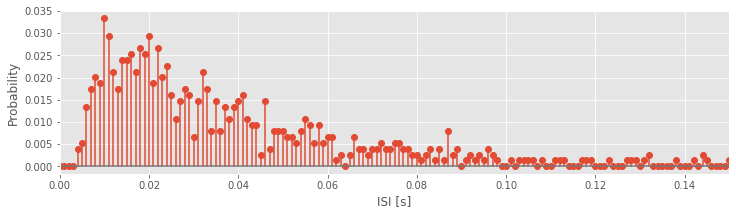

In [25]:
bins = np.arange(0, .5, 0.001)           # Define 1 ms bins for histogram,
counts, _ = np.histogram(ISIsLow, bins)  # ... compute histogram of the ISIs,
prob = counts / len(ISIsLow)             # ... convert to probability,
fig, ax = plt.subplots()                 # ... create figure and axes objects that we can reuse later,
ax.stem(bins[:-1], prob)                 # ... and plot the probabilities,
ax.set_xlim([0, 0.15])                   # ... with fixed x-limits,
xlabel('ISI [s]')                        # ... and axes labeled.
ylabel('Probability')
show()

Now, on the same figure, let's choose a value for $\lambda$ and plot the statistical model (<a href="#eq:7" class="thumb">7<span><img src="imgs/eq7.png"></span></a>):

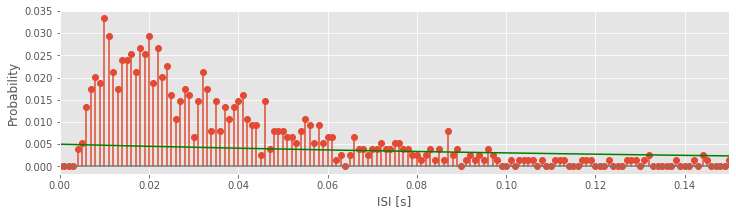

In [26]:
l = 5                                    # Choose a value for lambda,
model = l * np.exp(-l * bins) * 0.001    # ... and create the model,
ax.plot(bins, model, 'g')                # ... and plot the model in green
fig

In this code, we have chosen $\lambda$ = 5 Hz and evaluated the statistical model at each time bin. We’ve also scaled the statistical model by a factor of 0.001 to match the 1 ms bin size, and plotted the model on top of the empirical ISI probability distribution.

<div class="question">

**Q.** Try using some different values of $\lambda$. What values of $\lambda$ appear to provide a good fit to the empirical distribution of ISI values?

</div>

The process of guessing values of $\lambda$ and comparing the model (<a href="#eq:7" class="thumb">7<span><img src="imgs/eq7.png"></span></a>) to the empirical ISI distribution is not satisfying. How do we identify the parameter $\lambda$ that best fits the observed ISI distribution? We now consider a procedure to do so. Our goal is to find the value of $\lambda$ that maximizes the likelihood of the data given the statistical model (<a href="#eq:7" class="thumb">7<span><img src="imgs/eq7.png"></span></a>); this value of $\lambda$ will be the best fit of the model to the data. To implement this procedure, let’s consider the probability density of observing a sequence of ISIs, $x_1, x_2, ..., x_n$. If we assume that the ISIs are independent, then the probability density is
<a id="eq:8"></a>

$$
\begin{eqnarray}
f(x_1, x_2, ..., x_n) &=& f(x_1) f(x_2) ... f(x_n) \\ 
&=& \lambda \exp(-\lambda x_1) \lambda \exp(-\lambda x_2) ... \lambda \exp(-\lambda x_n) \\
&=& \lambda ^n \exp(-\lambda \sum_{i=1}^n x_i).
\end{eqnarray}
\tag{8}
$$

We call this expression the joint probability distribution of the observed data. In the first equality, we separate the joint probability distribution $f(x_1,x_2,...,x_n)$ into a product of probability distributions of each event (i.e., $f(x_1)$, the probability of the first ISI equaling $x_1$ , multiplied by $f(x_2)$, the probability of the second ISI equaling $x_2$, multiplied by $f(x_3)$, the probability of the third ISI equaling $x_3$, and so on). This partitioning of the joint probability is valid here because we assume the ISIs are independent. In the second equality, we replace each probability distribution with the exponential distribution we expect for the ISIs of a Poisson process. In the last equality, we rewrite the expression as a single exponential. Notice that this last expression is a function of the unknown rate parameter, $\lambda$.

When considered as a function of the unknown parameters, the joint distribution of the data (<a href="#eq:8" class="thumb">8<span><img src="imgs/eq8.png"></span></a>) is also called the *likelihood*. In this case, we write
<a id="eq:9"></a>

$$
L(\lambda) = \lambda^n e^{-\lambda (x_1 + x_2 + ... + x_n)},
\tag{9}
$$

to indicate that the likelihood $L$ is a function of $\lambda$. To understand what the likelihood function $L(\lambda)$ looks like , let's plot it. We do so for the data from the low-ight condition, and consider a range of possible $\lambda$ values.
<a id="fig:8-16"></a>

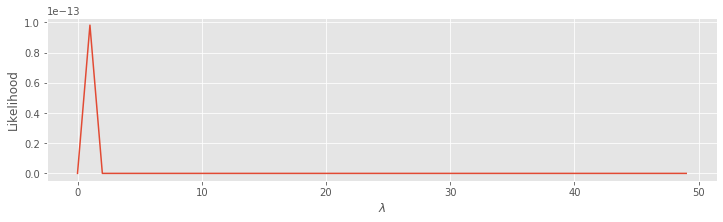

In [27]:
lambdas = np.arange(50)  # Range of lambda values.
N3 = len(ISIsLow)        # Number of low-light ISIs observed.
L = lambdas ** N3 * np.exp(-lambdas * sum(ISIsLow))  # Compute the likelihood,
plot(lambdas, L)         # ... and plot it
xlabel('$\lambda$')
ylabel('Likelihood')
show()

<div class="question">
    
**Q.** Consider the plot above. Does this answer seem okay?
  
**A.** Something went wrong here. The plot gives part of a line that rises toward $10^{-13}$ and is zero elsewhere. Why does this happen, and how can we fix it? To answer this, consider the first term in the likelihood function, $\lambda ^n$. In this case we are raising $\lambda$ to the power of `len(ISIsLow)` = 749. This is beyond the numerical precision limits of standard Python computations.

</div>

So, we can’t easily plot the likelihood directly. Instead, we plot the log of the likelihood. In this case, computing the log is useful because extremely large values are reduced to a more manageable range.
<a id="fig:8-17"></a>

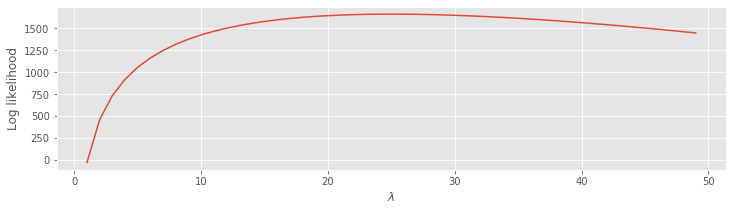

In [28]:
lambdas = lambdas[1:]  # Update the lambda range to exclude 0.
l = N3 * np.log(lambdas) - lambdas * sum(ISIsLow)  # Compute the log likelihood,
plot(lambdas, l)       # ... and plot it.
xlabel('$\lambda$')
ylabel('Log likelihood')
show()

<div class="question">

**Q.** Consider the second line of code above. Does the definition for `l` correspond to $\log[L(\lambda)]$ (<a href="#eq:9" class="thumb">eq.<span><img src="imgs/eq9.png"></span></a>)? *Hint*: It should. Remember $\log(x^a)=a \log x$, and $\log(e^b)=b$.

</div>

We see that the log likelihood is low for small $\lambda$, rises quickly as $\lambda$ increases, and then starts to fall off once $\lambda$ becomes larger than $\approx$ 25. The point $\lambda$ = 25, where the log likelihood is maximized, is called the maximum likelihood estimate of $\lambda$. We use the symbol $\hat\lambda$ to denote the maximum likelihood estimate of $\lambda$.

We observe that although the values of the likelihood go beyond the precision range in Python, the peak in the log likelihood stands out very clearly. Note that the likelihood (<a href="#fig:8-16" class="fig">figure<span><img src="imgs/8-16.png"></span></a>) is maximized at the same point as the log likelihood (<a href="#fig:8-17" class="fig">figure<span><img src="imgs/8-17.png"></span></a>). This is always true.

<div class="question">

**Q.** Can you explain why?

</div>

We could also have computed the maximum likelihood estimator theoretically, by differentiating the log likelihood with respect to $\lambda$, setting that equal to zero, and solving for $\lambda$. This gives $\frac{n}{\hat\lambda} - \sum_{i=1}^n x_i = 0$, which can be solved to find $\hat\lambda=(\sum_{i=1}^n x_i)^{-1} = 1 / \hat x = 25.0$ spikes/s. Remember that $x_i$ is the $i^{th}$ ISI value, so $\bar x$ is the average ISI value. This computation shows that the maximum likelihood estimate for the rate parameter of a Poisson process is just 1 divided by the average ISI value. For some statistical models, it is convenient to compute maximum likelihood estimates theoretically in this manner, but sometimes no closed-form solution exists. In these cases, we typically use numerical methods to solve for the maximum likelihood estimates.

<div class=question>
    
**Q.** What is the maximum likelihood estimate for the Poisson rate parameter in the high-light condition?

    
**A.** Repeating the analysis for the high-light condition, the maximum likelihood estimate for a Poisson rate parameter is $\hat \lambda = n(\sum{i=1}^nx_i)^{-1} = 1 / \bar x = 32.3$ spikes/s. The differenc ein the Poisson rate parameter of 32.3 - 25.0 = 7.3 spikes/s reflects the difference in the overall firing rate of the neuron between the low-and high-light conditions.
    
</div>

<div class=question>

**Q.** Is the difference in the Poisson rate parameter between the low-and high-light conditions statistically significant?

</div>

To address this last question, let’s use a bootstrap analysis (see [chapter 2](../2.%20The%20Event-Related%20Potential/The%20Event-Related%20Potential.ipynb#bootstrap)). We combine all the ISIs from both conditions into one pool, sample many new datasets with replacement from that pool, and compare the actual difference in rate parameters to the distribution of differences across the samples.

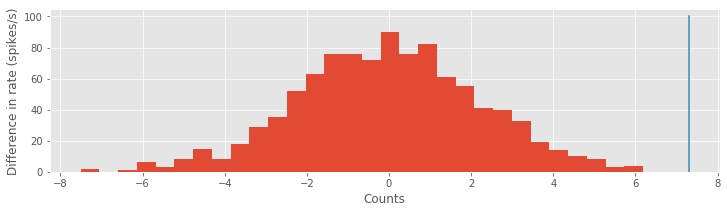

In [29]:
# Compute the observed difference in lambdas
MLDiff = 1 / ISIsHigh.mean() - 1 / ISIsLow.mean()

# Then, perform the bootstrap analysis.
ISIs = np.hstack([ISIsLow, ISIsHigh])  # Merge all ISIs.
Nall = len(ISIs)  # Save length of all ISIs.
Nlo = len(ISIsLow)  # Save length for the low-light condition
Nhi = len(ISIsHigh)  # Save length high-light condition

# Compute the difference in lambdas from resampled data
sampDiff = [1 / np.mean(ISIs[np.random.randint(Nall, size=Nhi)]) -  # Resample the high-light ISIs and subtract
           1 / np.mean(ISIs[np.random.randint(Nall, size=Nlo)])     # ... the resampled low-light ISIs
           for _ in range(1000)]                                    # ... 1000 times

# Compare the bootstrap distribution to the empirical
plt.hist(sampDiff, bins=30)       # Plot resampled ISIs distribution
plot([MLDiff, MLDiff], [0, 100])  # ... and the empirical ISIs.
xlabel('Counts')
ylabel('Difference in rate (spikes/s)')
show()

<div class=math-note>

There are more powerful tests we could use to compare the Poisson rate parameters. By more powerful, we mean that the tests are more likely to show a significant difference when one is actually present. However, the fact that the bootstrap test gives a significant result suggests that these more powerful tests would also be significant.

</div>

But, is the Poisson model good? To answer this, let’s visualize the model fits compared to the data. There are a number of ways to do this. We start by comparing the expected proportion of ISIs for a Poisson process to the ISI histograms we actually observe in each condition. Let’s do so first for the low-light condition:

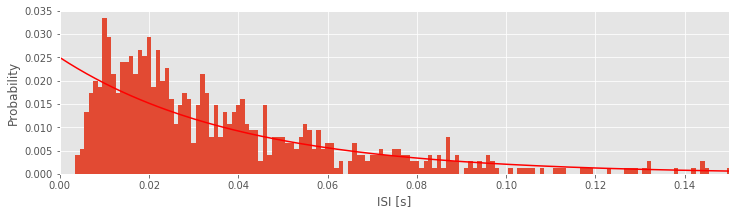

In [30]:
bins = np.arange(0, .5, 0.001)            # Define 1 ms bins for histogram
counts, _ = np.histogram(ISIsLow, bins)   # Compute histogram
prob = counts / len(ISIsLow)              # ... convert to probability,
plt.bar(bins[:-1], prob, width=0.001)     # ... and plot probability.
lbda = 1 / ISIsLow.mean()                 # Compute best guess for lambda,
model = lbda * np.exp(-lbda * bins) * 0.001  # ... build the model,
plot(bins, model, 'r')                    # ... and plot it
plt.xlim([0, 0.15])                       # ... xlim from 0 to 150 ms,
xlabel('ISI [s]')                         # ... label the x-axis,
ylabel('Probability')                     # ... and the y-axis
show()

<div class=question>

**Q.** Compare the model fit to the empirical ISI distribution for the low-light condition. Does the model fit the data?

**A.** No, the model does not provide a very good fit to the data. Since Poisson processes have spikes that are independent of past activity, they do not capture either the refractoriness (i.e., the few spikes observed at short times) or the bursting (i.e., the increased spiking at times 5–20 ms) that we observe in the data.

</div>

<div class=question>
    
**Q.** Repeat the analysis and compare the empirical ISI histogram to the best-fit model in the high-light condition. Does the model fit the data?
    
</div>

To go beyond visual inspection of the model fits and quantify the goodness of fit, we compare the cumulative distributions computed from the data and model. The *cumulative distribution function* (CDF), $F(x)$, is the probability that a random variable will take on a value less than or equal to $x$. For the exponential ISI model with rate parameter $\lambda$, the model CDF is

$$
\begin{eqnarray}
F_{mod}(x) &=& \Pr(\mbox{ISI} \leq x) \\
&=& \int_0^x \lambda e^{-\lambda t} dt \\
&=& 1 - e^{-\lambda x}.
\end{eqnarray}
$$

We compare this to the empirical CDF of the data, $F_{emp}(x)$, which is defined as the proportion of observations less than or equal to $x$. The code to compute and plot these CDFs for the low light-condition is as follows:

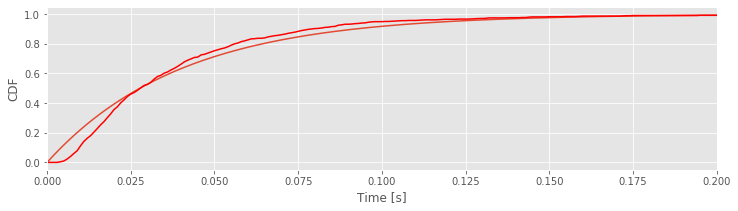

In [31]:
bins = np.arange(0, 0.5, 0.001)     # Define 1 ms bins for histogram
lbda = 1 / ISIsLow.mean()           # Compute best guess for lbda,
FmodLow = 1 - np.exp(-lbda * bins)  # ... and define model CDF.
FempLow = np.cumsum(prob)           # Define empirical CDF
plot(bins, FmodLow)                 # Plot the model CDF,
plot(bins[:-1], FempLow, 'r')       # ... and the empirical CDF,
plt.xlim([0, 0.2])                  # ... with specified x-limits
xlabel('Time [s]')
ylabel('CDF')
show()

<div class=question>
    
**Q.** Have you used the function `cumsum()` before? If not, look it up using `np.cumsum?`

</div>

<div class=question>

**Q.** Compare the model and empirical CDFs in the plot above. What do you think?

**A.** If the model were a perfect fit, the red and blue curves would align. However, that's not what we find here. We conclude that the model may not provide a good fit to the data.

</div>

<div class=question>

**Q.** Compare the model and empirical CDF for the data in the high-light condition. What do you find? Is the model a good fit to the data?

</div>

Another common way to visualize the difference between the model and empirical distributions is a *Kolmogorov-Smirnov* (KS) plot. This is just a plot of the empirical CDF against the model CDF directly.

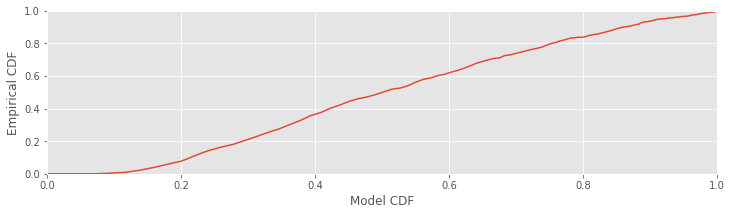

In [32]:
fig, ax = plt.subplots()
plot(FmodLow[:-1], FempLow)    # Plot the model vs empirical CDFs.
plt.axis([0, 1, 0, 1])         # Set the axes ranges.
xlabel('Model CDF')
ylabel('Empirical CDF')
show()

Since the KS plot compares CDFs, both the $x$-axis and $y$-axis range from 0 to 1. A perfect fit between the model and empirical CDFs would look like a straight, 45-degree line between the points (0,0) and (1,1). Any deviation from this line represents deviation between the observed and model distributions. One nice result for comparing CDFs is that with enough data, the maximum difference between the model and empirical CDFs has a known asymptotic distribution, which can be used to put confidence bounds about the KS plot [[Kass, Eden & Brown, 2014](http://dx.doi.org/10.1007/978-1-4614-9602-1)]. For 95% confidence bounds, a well-fit model should stay within ±1.36/$\sqrt N$ of the 45-degree line, where $N$ is the number of ISIs observed. Let’s place these confidence bounds on the KS plot:

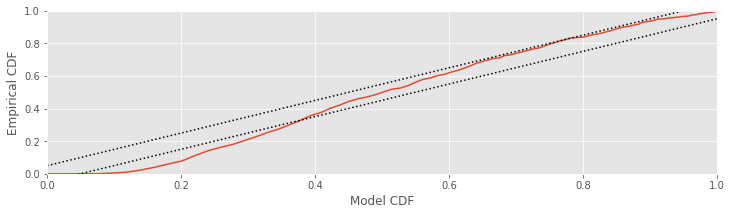

In [33]:
Nlow = len(ISIsLow)  # Length of the low-light condition
# Plot the confidence bounds
ax.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'k:')
ax.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'k:')
fig

A well-fit model should stay entirely within these bounds. In this case, the KS plot for the low-light condition extends well outside these bounds. The exponential ISI model—or equivalently, the Poisson process model—does not fit the data in the low-light condition well. This suggests that we need a better model if we want to make meaningful comparisons about differences in the structure of the data between the two conditions.

<div class=question>

**Q.** Compute the KS plto with 95% significance bounds or the high-light condition. Does the exponential ISI model fit the data well?

</div>

#### A More Advanced Statistical Model.
We’ve now investigated one class of models, the exponential distribution, to fit the observed ISI distributions. However, through analysis, we’ve found that this statistical model is not sufficient to mimic the observed data. There are many other choices for statistical models; let’s try one other class of models. The inverse Gaussian probability model has already been used successfully to describe ISI structure in this system [Hodgkin & Huxley, 1952](https://doi.org/10.1007/BF02459568). The mathematical expression for the inverse Gaussian probability density is 

$$
f(x) = \sqrt{\frac{\lambda}{2 \pi x^3}}\exp\left(\frac{-\lambda(x - \mu)^2}{2 x \mu^2}\right)
\tag{10}
$$

The inverse Gaussian distribution has two parameters that determine its shape: $\mu$, which determines the mean of the distribution, and $\lambda$, which is called the shape parameter. At $x$ = 0, the inverse Gaussian has a probability density equal to zero, which suggests it could capture some of the refractoriness seen in the data.

If we again assume that the ISIs are independent of each other, then the likelihood of observing the sequence of ISIs, $x_1 , x_2 , . . . , x_n$, is the product of the probabilities of each ISI,

$$
L(\mu, \lambda) = f(x_1, x_2, ..., x_n) = \prod_{i=1}^N\sqrt{\frac{\lambda}{2\pi x_i^3}}\exp\left(\frac{-\lambda(x_i - \mu)^2}{2 x_i \mu^2}\right)
\tag{11}
$$

The log likelihood is then

$$
\log\big(L(\mu, \lambda)\big) = \frac{N}{2}\log{\lambda}{2\pi} - \frac{3}{2}\sum_{i=1}^N \log{x_i} - \sum_{i=1}^N\frac{\lambda(x_i - \mu)^2}{2x_i \mu^2}.
\tag{12}
$$

Since this distribution has two parameters, the maximum likelihood solution for this model is the pair of parameter estimates $\hat\mu$, $\hat\lambda$ that maximizes the likelihood of the data. We can solve for the maximum likelihood estimate analytically by taking the derivative with respect to both parameters, setting these equal to zero, and solving the resulting set of equations. In this case, the maximum likelihood estimators are

$$
\hat\mu = \frac{1}{N}\sum_{i=1}^N x_i
\tag{13}
$$

and

$$
\hat\lambda = \left( \frac{1}{N}\sum_{i=1}^N\left(\frac{1}{x_i} - \frac{1}{\bar \mu}\right)\right)^{-1}.
\tag{14}
$$

Using this expression, we can fit an inverse Gaussian model to the data in each condition and evaluate the goodness-of-fit of the model. Let’s do so now for the low-light condition.

In [34]:
bins = np.arange(0, .5, 0.001)    # Define 1 ms bins.
Nlow = len(ISIsLow)               # Length of low-light condition.
mu = ISIsLow.mean()               # Mean of inverse Gaussian
lbda = 1 / (1 / ISIsLow - 1 / mu).mean()    # ... and shape parameter
model = (                                   # ... to create the model.
    np.sqrt(lbda / 2 / np.pi / bins ** 3) * 
    np.exp(-lbda * (bins - mu) ** 2 /       
           2 / mu ** 2 / bins) * 0.001
)
model[0] = 0                      # Numerator to 0 faster than denominator.
print('mu = ', mu)                # Display the MLEs
print('lambda = ', lbda)

mu =  0.039988397284383186
lambda =  0.04931816769253932


/anaconda3/envs/csn/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/envs/csn/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


<div class=python-note>

Note that the first element of `bins` is 0, so dividing by `bins` causes a divide by zero warning.

</div>

From the computations, we find maximum likelihood estimates $\mu$ = 40.0 ms and $\lambda$ = 49.3 ms in the low-light condition. Next, we plot the data and the model.

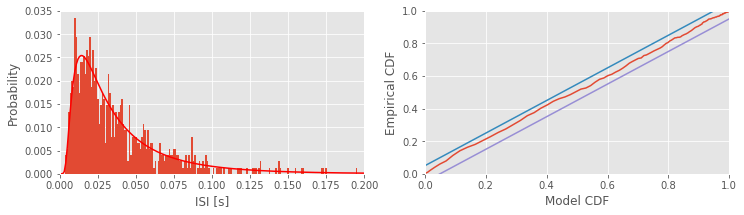

In [35]:
# Plot the data and the model,
plt.subplot(121)
counts, _ = np.histogram(ISIsLow, bins)  # Compute histogram,
prob = counts / len(ISIsLow)             # ... convert to probability,
plt.bar(bins[:-1], prob, width=1e-3)     # ... and plot probability
plot(bins, model, 'r')                   # Plot the model
plt.xlim([0, 0.2])                       # xlim from 0 to 200 ms.
xlabel('ISI [s]')                        # Label the axes
ylabel('Probability')

# Plot the KS plot
plt.subplot(122)
FmodLow = np.cumsum(model[:-1])          # Define the model CDF,
FempLow = np.cumsum(prob)                # ... and define empirical CDF,
plot(FmodLow, FempLow)                   # ... plot model vs empirical CDF,
plot([0, 1], np.arange(2) + 1.36 / np.sqrt(Nlow))  # ... upper confidence bound,
plot([0, 1], np.arange(2) - 1.36 / np.sqrt(Nlow))  # ... lower confidence bound,
plt.axis([0, 1, 0, 1])                   # ... set the axes ranges,
xlabel('Model CDF')                      # ... and label the axes.
ylabel('Empirical CDF')
show()

<div class=question>

**Q.** Consider the fit of the inverse Gaussian model to the data in the low-light condition. Does the inverse Gaussian model provide a good fit to the ISIs?

**A.** This model provides a much better fit to the data; the KS plot is contained within the 95% confidence bounds.

</div>

<div class=question>

**Q.** Consider the fit of the inverse Gaussian model to the data in the high-light con- dition. Does the inverse Gaussian model provide a good fit to these ISIs?

</div>

<div class=question>

**Q.** Compare the estimates of the two parameters $\mu$ and $\lambda$ of the inverse Gaussian model in the two conditions. What do these reveal about the differences between the low- and high-light conditions?

</div>

[Back to top](#top)
<a id="summary"></a>
## Summary
In this chapter, we considered the spiking activity recorded in two conditions. We began with visualizations of the spiking data, and construction and visualization of the increment process (i.e., binned spike counts). We then assessed the variability in the increments through computation of the Fano factor, and showed that the low- and high-light conditions had less and more variability, respectively, than expected for a Poisson process. We also assessed the autocorrelation of the increment processes and observed the impact of refractoriness and bursting activity. In addition, we created and visualized the ISIs for each condition. Inspection of the ISI histograms suggested bursting activity in both conditions, and more small ISIs in the high-light condition. Analysis of the ISI autocorrelations revealed no compelling evidence for dependence and supported the hypothesis of a renewal process. Finally, we built two statistical models of the observed ISIs. We discussed how to fit the model parameters by computing the maximum likelihood estimate, and how to evaluate the model goodness-of-fit to the data using the KS plot. We showed that the first model—the Poisson process as a model of spiking with a corresponding exponential distribution of ISIs—did not fit the observed ISI data. A second model—the inverse Gaussian probability model—provided a much more accurate fit to the observed ISIs. The modeling suggests that at least two features of the spiking activity have changed from the low-light to the high-light condition. First, the mean ISI is smaller, and hence the average firing rate is larger, in the high-light condition. Second, the shape of the firing distribution has changed so that the cell is more likely to fire in bursts with short ISIs in the high-light condition.

[Back to Top](#top)
<a id="appendix"></a>
## Appendix: Spike Count Mean and Variance for a Poisson Process

In this appendix, we compute the theoretical mean $\mu$ and the theoretical variance of the spike count $\sigma^2$ for a Poisson process. Let’s compute $\mu$ using a general formula that makes use of the probability $P(k)$ of observing $k$ spikes,
<a id="eq:15"></a>

$$
\mu = \sum_{k=1}^\infty k P(k).
$$

Replacing $P(k)$ with the expression for a Poisson distribution 
(<a href="#eq:6" class="thumb">eq.<span><img src="imgs/eq6.png"></span></a>)
, we find

$$
\begin{eqnarray}
\mu &=& \sum_{k=0}^\infty k\left(\frac{\lambda^k e^{-k}}{k!}\right) \\
&=& e^{-\lambda}\sum_{k=0}^\infty k\frac{\lambda^k}{k!}.
\end{eqnarray}
$$

To make progress, let's write out the terms in the summation,
<a id="eq:16"></a>

$$
\begin{eqnarray}
\mu &=& e^{-\lambda}
\left( 
0 + 
\frac{\lambda^1}{1!} + 
2\frac{\lambda^2}{2!} + 
3\frac{\lambda^3}{3!} + 
4\frac{\lambda^4}{4!} + 
\cdots 
\right) \\
&=& e^{-\lambda}\lambda
\left(
1 + 
\frac{\lambda^2}{2!} + 
\frac{\lambda^3}{3!} + 
\cdots 
\right) \\
&=& e^{-\lambda}\lambda(e^\lambda) \\
&=& \lambda,
\end{eqnarray}
$$

where we have used the fact that $e^x = 1 + \frac{x^2}{2!} + \frac{x^3}{3!} + \frac{x^4}{4!} + \cdots$. Notice that the mean spike count equals the rate parameter of the Poisson process.

To find the spike count variance for a Poisson process, we follow a similar procedure. In general, we compute the variance $\sigma^2$ of the spike count $k$ with probability distribution $P(k)$ as 
<a id="eq:17"></a>

$$
\sigma^2 = \sum_{k=0}^\infty k^2 P(k) - \left(\sum_{k=0}^\infty k P(k)\right) ^2.
$$

As in our computation of the mean spike count, we replace $P(k)$ with (<a href=#eq:6 class=thumb>eq.<span><img src=imgs/eq6.png></span></a>)
, the expression for a Poisson process. Notice that the second term is the square of the expression (<a href=#eq:15 class=thumb>eq.<span><img src=imgs/eq15.png></span></a>)
, and for a Poisson process we found $\mu = \lambda$. Therefore, let’s replace the second term in (<a href=#eq:17 class=thumb>eq.<span><img src=imgs/eq17.png></span></a>)
 with $\sigma^2$ and substitute for $P(k)$ in the first term of (<a href=#eq:17 class=thumb>eq.<span><img src=imgs/eq17.png></span></a>) to find
 
$$
\begin{eqnarray}
\sigma^2 &=&
\sum_{k=0}^\infty
k^2
\left(
\frac{\lambda^k e^{-\lambda}}{k!}
\right)
- \lambda^2
\\
&=&
e^{-\lambda}
\sum_{k=0}^\infty
k^2
\frac{\lambda^k}{k!} 
- \lambda^2.
\end{eqnarray}
$$

To make progress, we follow the same strategy and write out the terms in the summation,

$$
\begin{eqnarray}
\sigma^2
&=&
e^{-\lambda}
\left(
0 + 
\lambda +
2^2\frac{\lambda^2}{2!} + 
3^2\frac{\lambda^3}{3!} + 
4^2\frac{\lambda^4}{4!} + 
\cdots
\right) - 
\lambda^2
\\
&=&
\lambda e ^{-\lambda}
\left(
1 + 
2\lambda + 
\frac{3}{2}\lambda ^2 + 
\frac{4}{6}\lambda ^2 + 
\cdots
\right) - 
\lambda^2.
\end{eqnarray}
$$

Now, we divide this sum of terms into two pieces, a "nice term" (in the first brackets) and "leftovers" (in the second brackets):

$$
\sigma^2 = \lambda e^{-\lambda}
\left(
\left[
1 + 
\lambda + 
\frac{\lambda^2}{2!} + 
\frac{\lambda^3}{3!} + 
\cdots
\right] + 
\left[
\lambda + 
\frac{2\lambda^2}{2!} + 
\frac{3\lambda^3}{3!} + 
\cdots
\right] 
\right) - 
\lambda^2.
$$

We can simplify by recognizing that 
$\left[
1 + 
\lambda + 
\frac{\lambda^2}{2!} + 
\frac{\lambda^3}{3!} + 
\cdots
\right]
=
e^\lambda$.
Then
<a id="eq:18"></a>

$$
\begin{eqnarray}
\sigma^2
&=&
\lambda e^{-\lambda}
\left(
e^\lambda + 
\lambda
\left[
1 + 
\lambda + 
\frac{\lambda^1}{1!} + 
\frac{\lambda^2}{2!} + 
\cdots
\right] 
\right)-
\lambda^2 \\
&=&
\lambda e^{-\lambda}
\left(
e^\lambda + \lambda e^\lambda
\right)
-\lambda^2 \\
&=&
\lambda + \lambda^2 - \lambda^2 \\
&=&
\lambda,
\end{eqnarray}
$$

where again we've used the definition of $e^\lambda$. We conclude that the spike count variance for a Poisson precess equals the firing rate $\lambda$.

Combining these results for the mean spike count $\mu$ 
(<a href=#eq:16 class=thumb>eq.<span><img src=imgs/eq16.png></span></a>)
and the spike count variance
(<a href=#eq:18 class=thumb>eq.<span><img src=imgs/eq18.png></span></a>),
we conclude that for a Poisson process,

$$\mu = \sigma^2 = \lambda,$$

and therefore for a Poisson process, the Fano factor $\sigma^2/\mu=1$.

[Back to top](#top)

In [36]:
from IPython.core.display import HTML
HTML('../../assets/custom/custom.css')
# NO CODE